In [1]:
import os
import sys
print(os.getcwd())
sys.path.append("../WanPy")

from WanPy import *
from pythtb import *
from pythTB_wan import Bloch, K_mesh, Wannier, Lattice
import models
import plotting as plot

import numpy as np
import matplotlib.pyplot as plt
from matplotlib.colors import LogNorm

/Users/treycole/Codes/WanPy/tutorials


Setting up `pythTB` tight-binding model

In [2]:
delta = 1
t0 = 0.1
tprime = 0.5
n_super_cell = 2

model = models.chessboard(t0, tprime, delta).make_supercell([[n_super_cell, 0], [0, n_super_cell]])

low_E_sites = np.arange(0, model.get_num_orbitals(), 2)
high_E_sites = np.arange(1, model.get_num_orbitals(), 2)
lat_vecs = model.get_lat()
orb_vecs = model.get_orb()
n_orb = model.get_num_orbitals()
n_occ = int(n_orb/2)

u_wfs_full = wf_array(model, [20, 20])
u_wfs_full.solve_on_grid([0, 0])
chern = u_wfs_full.berry_flux([i for i in range(n_occ)])/(2*np.pi)

print(f"Low energy sites: {low_E_sites}")
print(f"High energy sites: {high_E_sites}")
print(f"Chern #: {chern: .1f}")
model.display()

Low energy sites: [0 2 4 6]
High energy sites: [1 3 5 7]
Chern #: -0.0
---------------------------------------
report of tight-binding model
---------------------------------------
k-space dimension           = 2
r-space dimension           = 2
number of spin components   = 1
periodic directions         = [0, 1]
number of orbitals          = 8
number of electronic states = 8
lattice vectors:
 #  0  ===>  [     2.0 ,     0.0 ]
 #  1  ===>  [     0.0 ,     2.0 ]
positions of orbitals:
 #  0  ===>  [     0.0 ,     0.0 ]
 #  1  ===>  [    0.25 ,    0.25 ]
 #  2  ===>  [     0.0 ,     0.5 ]
 #  3  ===>  [    0.25 ,    0.75 ]
 #  4  ===>  [     0.5 ,     0.0 ]
 #  5  ===>  [    0.75 ,    0.25 ]
 #  6  ===>  [     0.5 ,     0.5 ]
 #  7  ===>  [    0.75 ,    0.75 ]
site energies:
 #  0  ===>      -1.0
 #  1  ===>       1.0
 #  2  ===>      -1.0
 #  3  ===>       1.0
 #  4  ===>      -1.0
 #  5  ===>       1.0
 #  6  ===>      -1.0
 #  7  ===>       1.0
hoppings:
<  0 | H |  4 + [  0 ,  0 ] >  

To initialize the Wannier class instance, we must pass the model and the number of points along each reciprocal lattice basis vector. 

In [22]:
nks = 20, 20
WF = Wannier(model, nks)

The Wannier instance will initialize a `Bloch` instance associated with the energy eigenstates, another `Bloch` instance associated with the smoothened (tilde) states to Fourier transform into Wannier states, a `Lattice` instance keeping track of the geometry of our tight-binding lattice, and a `K_mesh` to store the k-points and nearest neighbor weights.

In [25]:
from pprint import pprint
pprint(vars(WF))

{'K_mesh': <pythTB_wan.K_mesh object at 0x106b8dd80>,
 'Lattice': <pythTB_wan.Lattice object at 0x106b8edd0>,
 '_model': <pythtb.tb_model object at 0x103cc80a0>,
 '_nks': (20, 20),
 'energy_eigstates': <pythTB_wan.Bloch object at 0x106b8f130>,
 'tilde_states': <pythTB_wan.Bloch object at 0x10609a440>}


The tilde states need to be initialized by single shot projection, performed by the `Wannierize` class method. We can see that the states have yet to be initialized by trying to retrieve the states from `tilde_states`.

In [27]:
WF.tilde_states.get_states()

AssertionError: Need to call `solve_model` or `set_wfs` to initialize Bloch states

`Wannierize` only requires the list of trial wavefunctions as an argument. The list can either be a list of integers, marking delta functions on sites corresponding to each integer, or a list of tuples where the first element corresponds to the lattice site and the second element is the relative weight. Normalizing occurs internally, the weight ratio on each site is preserved. 

Since we are in the trivial phase, we chose a number of trial wavefunctions equal to the number of bands in our target subspace, the occupied subspace in this case. We will chose delta functions on the lower energy sites in the unit cell as our trial wavefunctions.

In [30]:
tf_list = list(low_E_sites)

n_tfs = len(tf_list)
Wan_frac = n_tfs/n_occ
print(f"Trial wavefunction list: {tf_list}")
print(f"# of Wannier functions: {n_tfs}")
print(f"# of occupied bands: {n_occ}")
print(f"Wannier fraction: {Wan_frac}")

Trial wavefunction list: [0, 2, 4, 6]
# of Wannier functions: 4
# of occupied bands: 4
Wannier fraction: 1.0


After calling the `Wannierize` method passing the `tf_list`, the tilde states will be initialized by projecting the trial wavefunctions onto the Bloch energy eigenstates to form the Bloch-like states with a smoothened gauge. 

In [32]:
WF.Wannierize(tf_list)
WF.tilde_states.get_states()

{'Bloch': array([[[[ 9.44036917e-01+4.82931271e-34j,
            1.62528792e-01+2.65236402e-17j,
           -2.77555756e-17+6.09256832e-18j, ...,
           -7.59836928e-18+1.62528792e-01j,
            5.59630830e-02+3.51251437e-20j,
           -1.62528792e-01-3.57579923e-18j],
          [ 8.32667268e-17-1.11236577e-18j,
           -7.83020511e-17-1.62528792e-01j,
            9.44036917e-01+6.01534685e-17j, ...,
           -1.62528792e-01-1.29008723e-16j,
            2.49800181e-16-2.42939892e-17j,
           -2.50726788e-16+1.62528792e-01j],
          [ 5.55111512e-17+7.23726101e-19j,
            7.41201728e-17+1.62528792e-01j,
            5.59630830e-02+2.03434194e-17j, ...,
            1.62528792e-01+1.83548313e-16j,
           -5.55111512e-17+2.47282142e-17j,
            2.03838522e-16-1.62528792e-01j],
          [ 5.59630830e-02-4.11053739e-20j,
           -1.62528792e-01-2.36522223e-17j,
            8.32667268e-17-2.12474736e-17j, ...,
            1.70060026e-17-1.62528792e-01j,


We can plot the resulting Wannier functions using the `plot` class method. The only argument required is the Wannier index. This will plot the Wannier function density on a discrete lattice formed by the model we have chosen. Optionally, we can pass booleans `plot_phase` and `plot_decay` to plot the Wannier function phase on the lattice and the Wannier weight as a function of radius away from the home unit cell. 

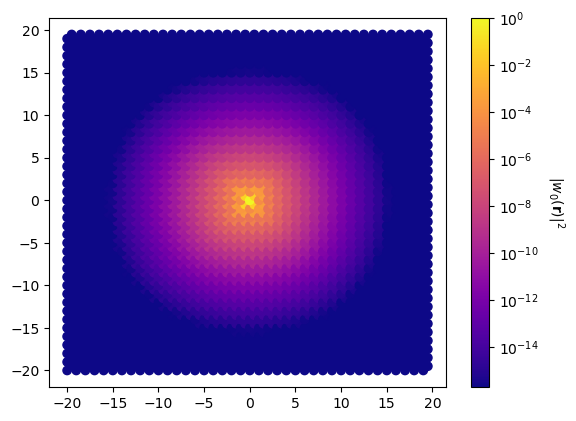

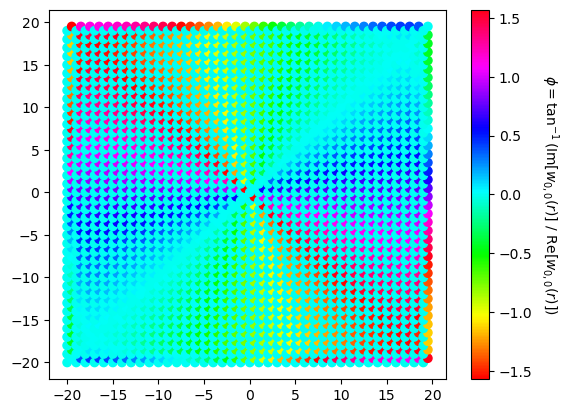

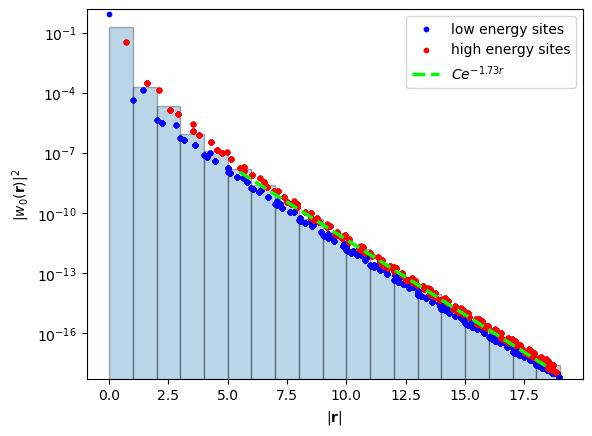

In [35]:
fig, ax = WF.plot(0, plot_decay=True, plot_phase=True)

To see information about the spread and Wannier centers we can call the `report` method.

In [36]:
WF.report()

Wannier function report
 --------------- 
Quadratic spread = [0.08115266 0.08115266 0.08115266 0.08115266]
Omega_i = 0.2960087797551978
Omega_tilde = 0.028601848004005465
Wannier centers: 
 [[-7.62698117e-18 -2.89549195e-18]
 [-2.68152234e-18  1.00000000e+00]
 [ 1.00000000e+00  3.65301338e-18]
 [ 1.00000000e+00  1.00000000e+00]]
